<a href="https://colab.research.google.com/github/Shubhranshu331/Handwritten-Digit-Recognition/blob/main/Handwritten_Digit_Recognition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T055846Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3a0ffff0e598ce3f54c1b15386701efca8599a3a52cb8bd9fd35f8d2ea40e7234c680dd39444b1d5f4a4d85286b48db4c7b6b9a8415bfb2c530fe3daab4b7170c04b6c495797abc34ba675857516a66edcc39bd57f00318613a94d8982ce937667675c1a7a1531607276b9b0be5c1275cc1a3ae4f141cb86133c6e455bed1776d8446a596ccc9143e2e8277224986c36b74eb197422a8df51ab0b27ed37126ff8d0544fd38faca7dabd3845688bded7dffa2726f6c5fc522fe6b2669d963b16af2fa57640d4418e6a3347b0cedfd640aaf7a28dad2853b805b2f4350027247bd216ef0491d3eeb7a263365e9161cbdea277a0d2f78bbf11d91d8f3c37645d57b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf # tools for building and training neural
                        #networks,handling data, and visualizing results.
import matplotlib.pyplot as plt # provides an implicit, MATLAB-like way of creating plots.
import seaborn as sn # default styles and color palettes to create
                     # attractive statistical plots.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import datetime
import platform # access to underlying platform information, including hardware
                # details, operating system specifics, and interpreter version data.

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [6]:
# print('Python version:', platform.python_version())
# print('Tensorflow version:', tf.__version__)
# print('Keras version:', tf.keras.__version__)

In [7]:
# load the tensorboard notebook extension
%load_ext tensorboard

In [8]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

dimention of train and test data

In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train.info(), train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


(None, (42000, 785))

In [11]:
test.info(), test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


(None, (28000, 784))

In [12]:
X = train.iloc[:, 1:785]
y = train.iloc[:, 0]

X_test = test.iloc[:, 0:784]

**Visualising the data using tsne(t-distribiuted stochastic neighbour embedding)**

*Dimensionality Reduction: Imagine a dataset with hundreds or even thousands of features. t-SNE takes this high-dimensional data and transforms it into a lower-dimensional space, typically 2 or 3 dimensions, which is much easier to visualize.
*Preserving Relationships: While reducing the dimensions, t-SNE tries to maintain the relationships between the data points. Data points that were similar in the high-dimensional space will ideally be close together in the lower-dimensional visualization. This allows you to see clusters, patterns, and groupings in the data.
*Non-Linear: Unlike some dimensionality reduction methods, t-SNE is non-linear. This means it can capture more complex relationships between data points that wouldn't be possible with a linear transformation.

In [13]:
X_tsn = X/255

from sklearn.manifold import TSNE
tsne = TSNE()

tsne_res = tsne.fit_transform(X_tsn)

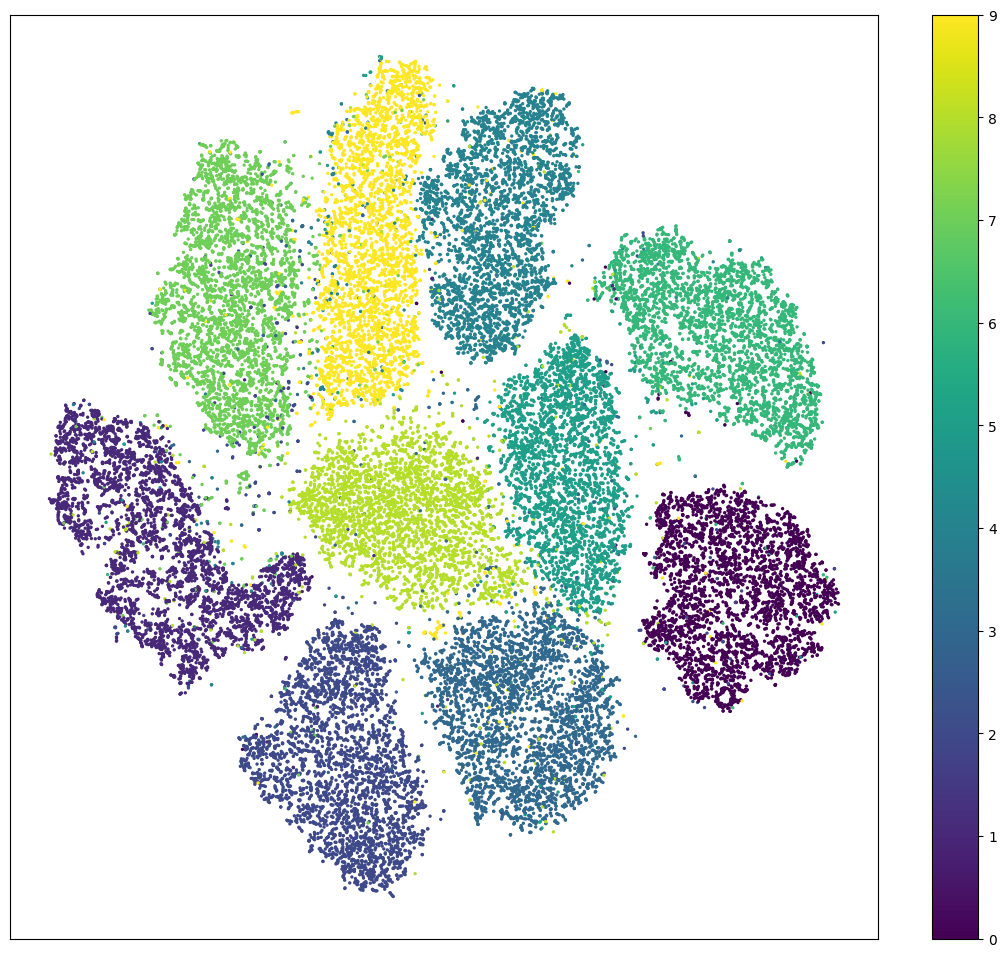

In [14]:
plt.figure(figsize = (14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar()

We are dividing our dataset (X) into two parts.

The training dataset (80%) is used to fit our models
The Validation dataset (20%) is used to evaluate our models
train_test_split() method returns us the training data, its labels and also the validation data and its labels.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2,
                                                                random_state = 1212)

In [16]:
# dimensions of training and testing data

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_validation: ", X_validation.shape)
print("y_validation: ", y_validation.shape)

X_train:  (33600, 784)
y_train:  (33600,)
X_validation:  (8400, 784)
y_validation:  (8400,)


In [17]:
# converting training, testing and validation data into arays

x_train_re = X_train.to_numpy().reshape(33600,28,28)
y_train_re = y_train.values
x_validation_re = X_validation.to_numpy().reshape(8400,28,28)
y_validation_re = y_validation.values
x_test_re = test.to_numpy().reshape(28000,28,28)

In [18]:
# dimensions of training testing and validation data after reshaping

print("x_train: ",x_train_re.shape)
print("y_train: ",y_train_re.shape)
print("x_validation: ",x_validation_re.shape)
print('y_validation: ',y_validation_re.shape)
print("x_test: ",x_test_re.shape)

x_train:  (33600, 28, 28)
y_train:  (33600,)
x_validation:  (8400, 28, 28)
y_validation:  (8400,)
x_test:  (28000, 28, 28)


In [19]:
# saving image parameters to the constants that we will use later for data_reshaping
#and model trainig

(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train_re.shape
IMAGE_CHANELS = 1

print("IMAGE_WIDTH: ", IMAGE_WIDTH)
print("IMAGE_HEIGHT: ",IMAGE_HEIGHT)
print("IMAGE_CHANELS: ",IMAGE_CHANELS)

IMAGE_WIDTH:  28
IMAGE_HEIGHT:  28
IMAGE_CHANELS:  1


In [20]:
# explore the data

pd.DataFrame(x_train_re[0])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,155,155,12,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,254,254,103,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,254,254,55,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,254,254,20,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,254,170,6,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,242,37,0,0,0,0,0,0,0,0


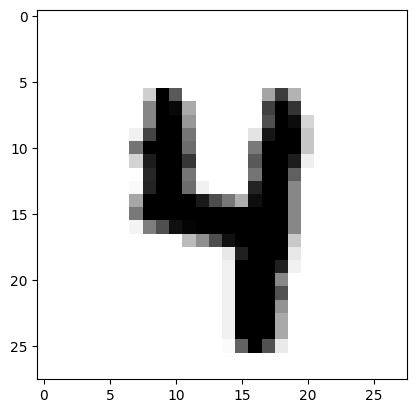

In [21]:
# visualizing how digits are written

plt.imshow(x_train_re[1], cmap=plt.cm.binary)
plt.show()

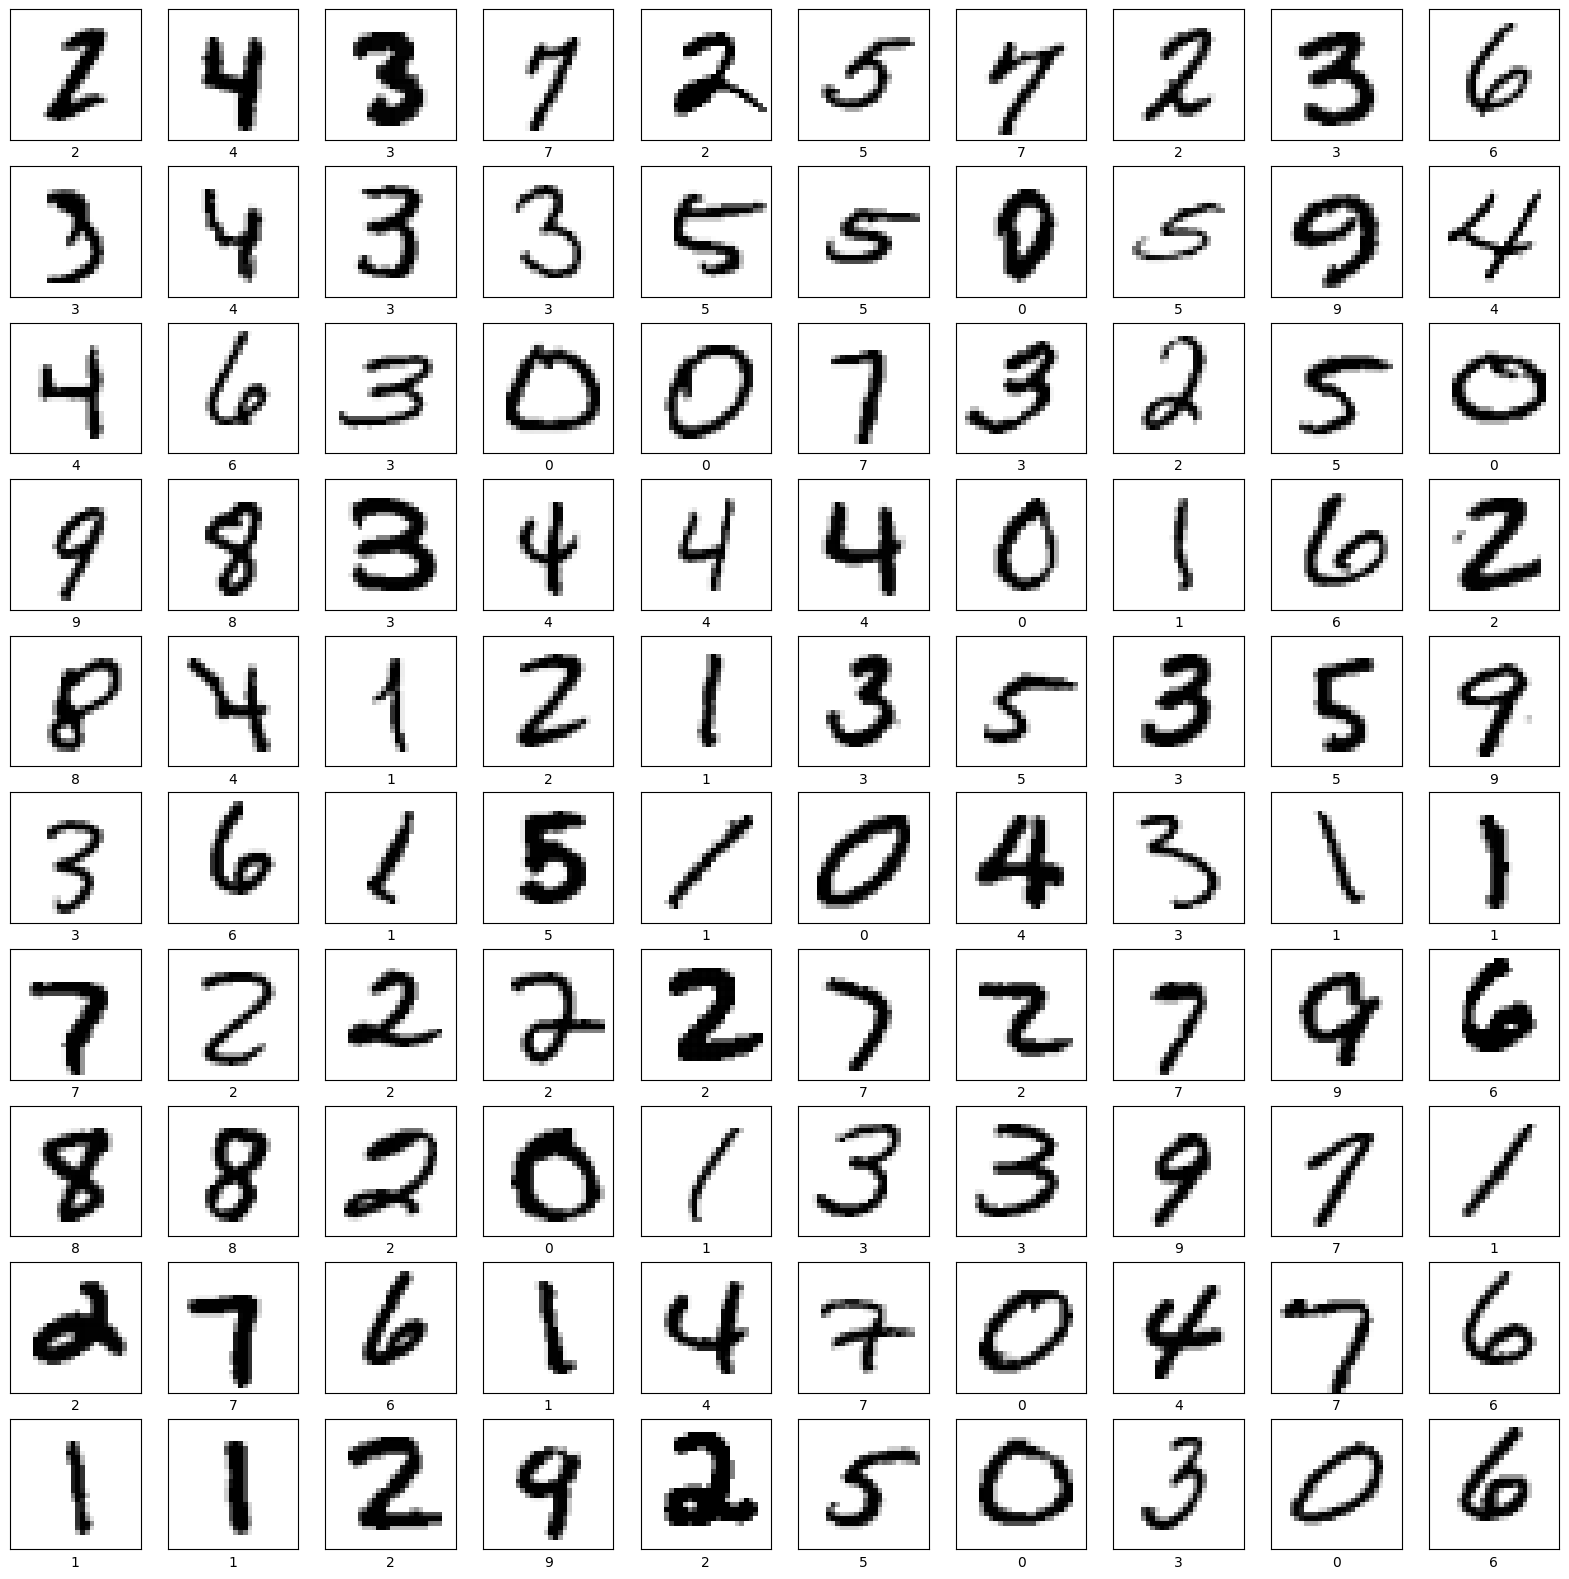

In [22]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize = (20, 20))
for i in range (numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_re[i], cmap = plt.cm.binary)
    plt.xlabel(y_train_re[i])

In [23]:
# reshaping test, validation and train data

x_train_with_chanels = x_train_re.reshape(
    x_train_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANELS
)
x_validation_with_chanels = x_validation_re.reshape(
    x_validation_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANELS
)
x_test_with_chanels = x_test_re.reshape(
    x_test_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANELS
)

In [24]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_validation_with_chanels:', x_validation_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (33600, 28, 28, 1)
x_validation_with_chanels: (8400, 28, 28, 1)
x_test_with_chanels: (28000, 28, 28, 1)


In [25]:
# normalise train, test and validation data

x_train_normalized = x_train_with_chanels / 255
x_validation_normalized = x_validation_with_chanels /255
x_test_normalized = x_test_with_chanels /255

In [26]:
# Let's check just one row from the 0th image to see color chanel values
# after normalization.
x_train_normalized[0][10]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.02352941],
       [0.99607843],
       [0.99607843],
       [0.99607843],
       [0.76862745],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

**building the cnn model to classify the handwritten digits**

A Convolutional Neural Network model generally consists of convolutional and pooling layers. using Sequential Keras model which have two pairs of Convolution2D and MaxPooling2D layers. The MaxPooling layer acts as a sort of downsampling using max values in a region instead of averaging.

In [27]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size = (2, 2),
    strides = (2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size = 5,
    filters = 16,
    strides = 1,
    activation = tf.keras.activations.relu,
    kernel_initializer = tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size = (2, 2),
    strides = (2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units = 128,
    activation = tf.keras.activations.relu
))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(
    units = 10,
    activation = tf.keras.activations.softmax,
    kernel_initializer = tf.keras.initializers.VarianceScaling()
))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          3216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

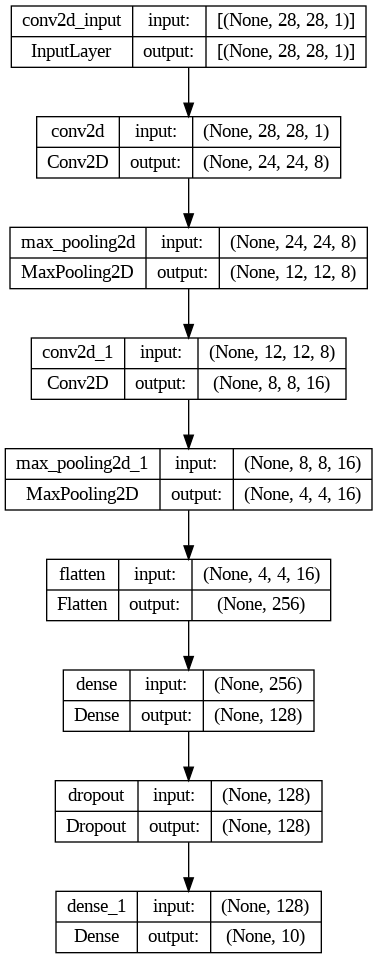

In [29]:
# visualization of the model

tf.keras.utils.plot_model(
    model,
    show_shapes =True,
    show_layer_names = True
)

In [30]:
# compiling the model now

adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(
    optimizer = adam_optimizer,
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ['accuracy']
)

In [31]:
# train the  model

log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train_normalized,
    y_train_re,
    epochs=10,
    validation_data=(x_validation_normalized, y_validation_re),
    callbacks=[tensorboard_callback]
)

print("The model has successfully trained")

Epoch 1/10
1050/1050 [==============================] - 19s 17ms/step - loss: 0.2815 - accuracy: 0.9134 - val_loss: 0.0920 - val_accuracy: 0.9711
Epoch 2/10
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0841 - accuracy: 0.9743 - val_loss: 0.0599 - val_accuracy: 0.9811
Epoch 3/10
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0604 - accuracy: 0.9816 - val_loss: 0.0584 - val_accuracy: 0.9826
Epoch 4/10
1050/1050 [==============================] - 16s 16ms/step - loss: 0.0499 - accuracy: 0.9838 - val_loss: 0.0487 - val_accuracy: 0.9832
Epoch 5/10
1050/1050 [==============================] - 16s 16ms/step - loss: 0.0408 - accuracy: 0.9874 - val_loss: 0.0432 - val_accuracy: 0.9869
Epoch 6/10
1050/1050 [==============================] - 18s 17ms/step - loss: 0.0314 - accuracy: 0.9895 - val_loss: 0.0524 - val_accuracy: 0.9846
Epoch 7/10
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0286 - accuracy: 0.9909 - val_loss: 0.0449 -

**Model Evaluation**

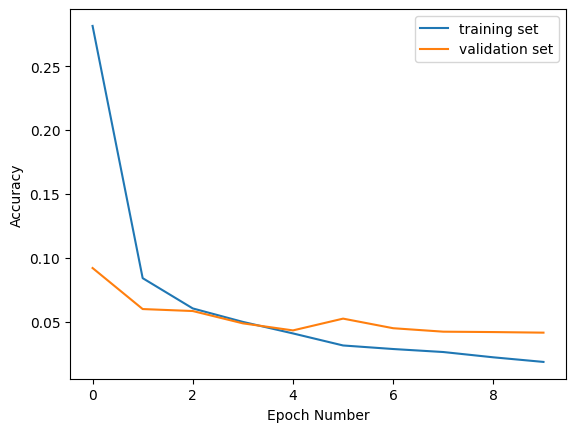

In [32]:
# loss plot curve for taining and validation

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='validation set')
plt.legend()

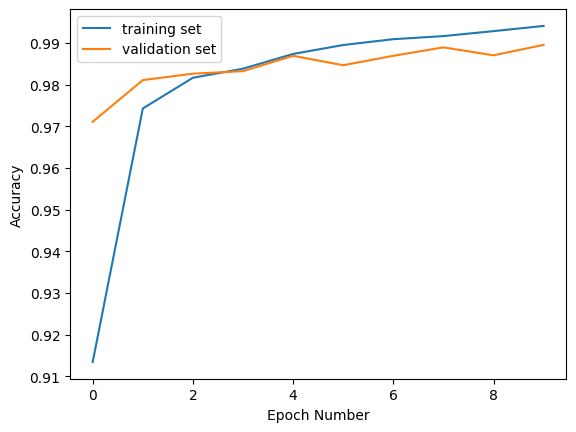

In [33]:
# Accuracy plot curve for training and validation

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='validation set')
plt.legend()

**Performance of training dataset**

In [34]:
%%capture
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train_re)

In [35]:
print('Train loss: ', train_loss)
print('Train accuracy: ', train_accuracy)

Train loss:  0.008435833267867565
Train accuracy:  0.9975892901420593


**Performance of validation dataset**

In [36]:
%%capture
validation_loss, validation_accuracy = model.evaluate(x_validation_normalized, y_validation_re)

In [37]:
print('Train loss: ', validation_loss)
print('Train accuracy: ', validation_accuracy)

Train loss:  0.04143268242478371
Train accuracy:  0.9895238280296326


**Save and load the model**

In [38]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
loaded_model = tf.keras.models.load_model(model_name)

**Visualise validation predicted data on how the digits were written**

In [40]:
predictions_one_hot = loaded_model.predict([x_validation_normalized])

263/263 [==============================] - 1s 5ms/step


In [41]:
print('predictions_one_hot:', predictions_one_hot.shape)

predictions_one_hot: (8400, 10)


In [42]:
# Predictions in form of one-hot vectors (arrays of probabilities).
pd.DataFrame(predictions_one_hot)

,0,1,2,3,4,5,6,7,8,9
0,4.748462e-07,9.999993e-01,2.538068e-08,4.153118e-12,4.463231e-09,1.998560e-10,2.209077e-08,9.652623e-09,1.267010e-07,1.984103e-11
1,2.713332e-10,2.394762e-05,8.059431e-09,9.999183e-01,8.708396e-08,2.357596e-06,2.228988e-13,1.518075e-07,2.735791e-07,5.479831e-05
2,1.102603e-12,1.247246e-09,1.206742e-06,1.451071e-06,1.109287e-10,2.140428e-07,6.455120e-10,7.552421e-12,9.999971e-01,4.657832e-08
3,4.577945e-10,9.999979e-01,6.480899e-09,6.967002e-11,1.871662e-06,6.158739e-09,1.060121e-09,1.185264e-07,1.229146e-08,2.247491e-11
4,1.549514e-13,1.529693e-16,3.899007e-14,8.395206e-11,1.791492e-09,1.005230e-12,1.386602e-20,2.319442e-09,4.385924e-09,9.999999e-01
...,...,...,...,...,...,...,...,...,...,...
8395,3.734460e-13,5.106346e-14,7.186555e-11,1.391380e-14,9.999999e-01,1.807195e-11,6.534798e-12,6.172633e-15,2.568853e-13,4.021341e-10
8396,2.574724e-11,1.811366e-14,8.461707e-21,1.474867e-11,1.096533e-13,9.999987e-01,1.250480e-06,2.329192e-17,1.034723e-09,3.985564e-13
8397,3.942663e-10,6.922826e-09,2.311165e-09,6.089595e-09,5.820395e-05,4.944392e-08,2.212774e-13,9.983448e-01,1.802491e-07,1.596846e-03
8398,5.261473e-09,5.530797e-13,5.323868e-13,4.746905e-12,2.685295e-12,2.870960e-09,9.999999e-01,1.847760e-18,9.178819e-10,4.208291e-13


In [43]:
# Let's extract predictions with highest probabilites and detect what digits have been actually recognized.
predictions = np.argmax(predictions_one_hot, axis=1)
pd.DataFrame(predictions)

,0
0,1
1,3
2,8
3,1
4,9
...,...
8395,4
8396,5
8397,7
8398,6


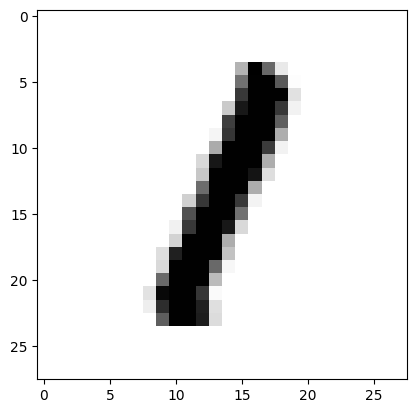

In [44]:
plt.imshow(x_validation_normalized[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

<ipython-input-45-6e85d9dbcc06>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


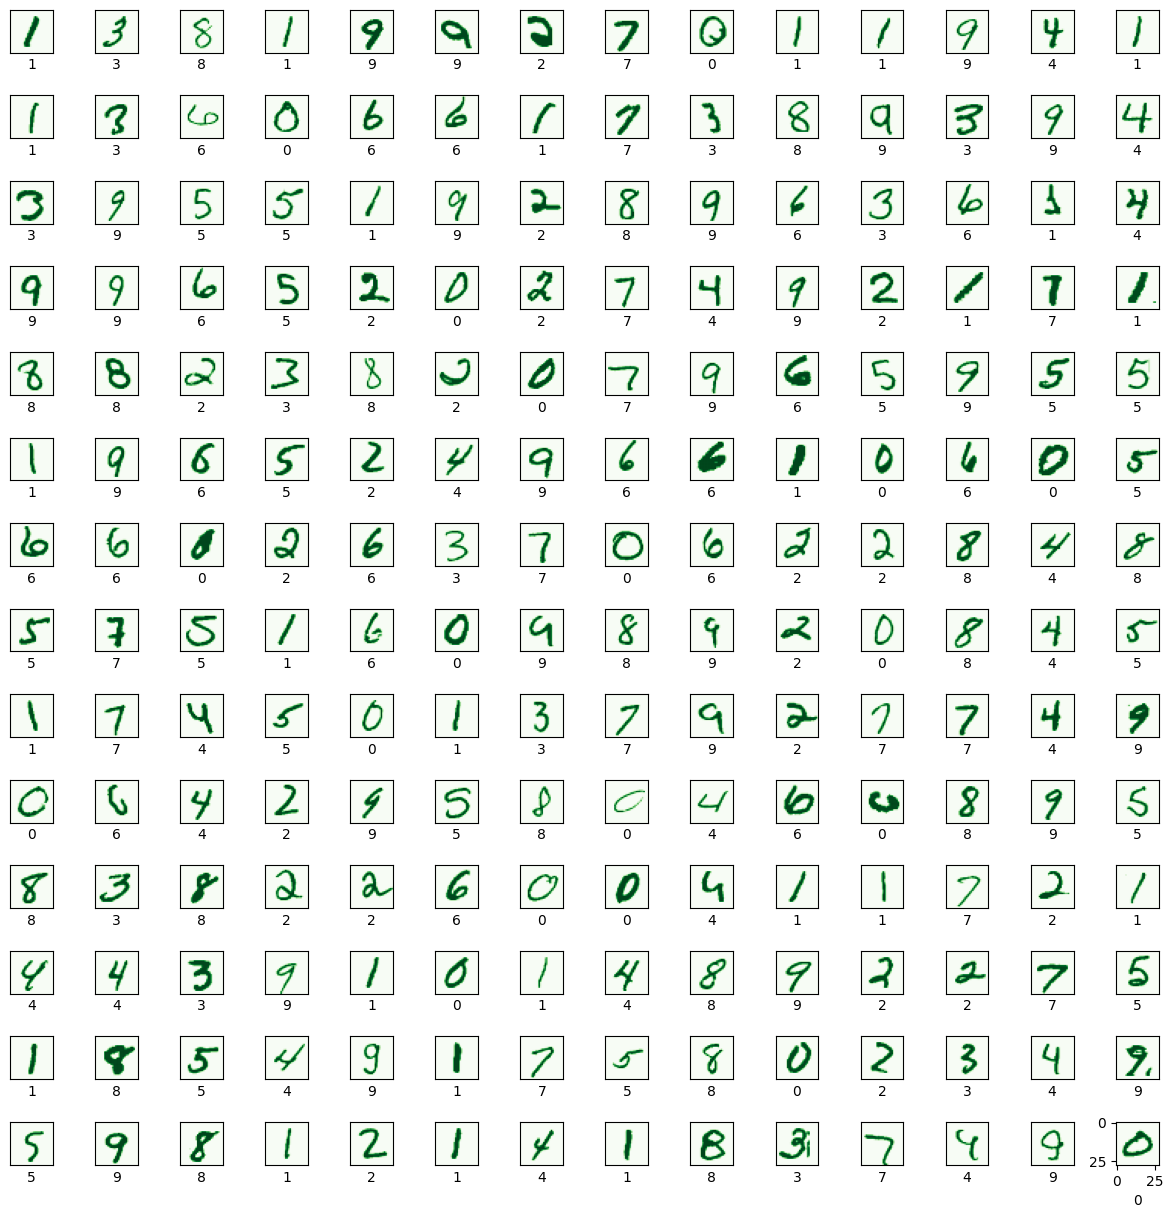

In [45]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens'if predicted_label == y_validation_re[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_validation_normalized[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

**Confusion matrix of validation daatset**

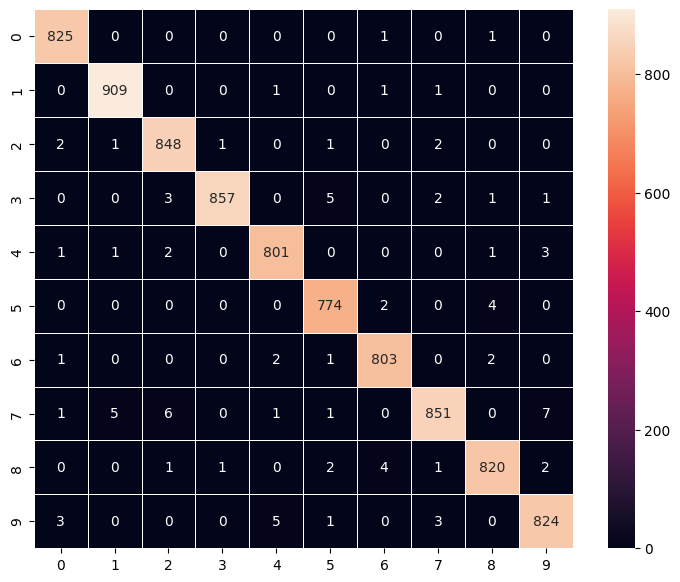

In [46]:
confusion_matrix = tf.math.confusion_matrix(y_validation_re, predictions)
f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Model prediction of unseen dataset**

In [47]:
predictions_one_hot = loaded_model.predict([x_test_normalized])
print('predictions_one_hot:', predictions_one_hot.shape)

875/875 [==============================] - 5s 6ms/step
predictions_one_hot: (28000, 10)


In [48]:
pd.DataFrame(predictions_one_hot)

,0,1,2,3,4,5,6,7,8,9
0,7.820474e-10,3.212200e-09,9.999990e-01,6.202198e-07,9.724109e-10,6.500259e-12,9.556929e-14,3.259109e-07,3.669630e-09,8.408712e-10
1,9.999869e-01,1.124888e-09,9.419366e-11,2.051301e-10,3.823579e-11,6.909345e-06,4.844397e-06,3.139152e-09,4.682018e-09,1.144174e-06
2,8.711119e-12,3.776294e-12,5.012467e-10,5.639057e-09,1.345771e-06,8.953899e-12,2.951742e-16,4.355207e-09,1.128715e-07,9.999985e-01
3,2.643878e-01,2.748197e-09,3.820369e-07,1.624887e-05,6.732948e-06,5.062518e-07,2.247121e-04,2.251714e-09,3.262696e-05,7.353309e-01
4,4.071038e-08,4.161188e-05,1.264230e-03,9.981726e-01,6.720766e-09,1.231170e-06,9.126779e-10,6.083633e-06,5.115846e-04,2.622784e-06
...,...,...,...,...,...,...,...,...,...,...
27995,3.453658e-10,2.128164e-16,1.983815e-12,1.836644e-09,5.056474e-09,1.077050e-08,2.121146e-16,1.900296e-08,5.840954e-08,9.999999e-01
27996,1.949313e-08,6.675274e-10,4.938807e-06,2.371432e-07,2.536203e-05,1.519153e-07,1.491585e-13,9.995050e-01,5.677661e-10,4.643181e-04
27997,9.683669e-19,8.398780e-14,1.082715e-15,9.999999e-01,1.426511e-16,2.608141e-10,1.154191e-20,1.952999e-12,3.087559e-10,2.990856e-12
27998,1.930304e-10,3.841008e-13,9.525394e-12,1.850121e-09,7.389844e-06,4.765419e-09,3.500744e-15,1.009205e-07,1.121415e-09,9.999924e-01


**Visualise test predicted data how the digits were written**

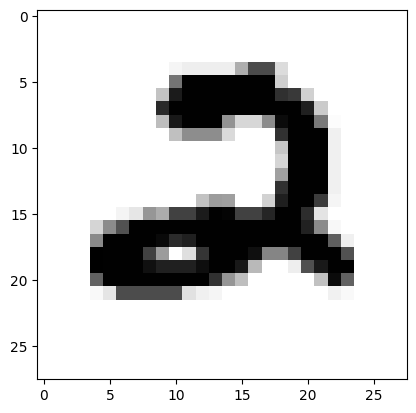

In [49]:
plt.imshow(x_test_normalized[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

**Submition**

In [50]:
test_pred = pd.DataFrame( loaded_model.predict([x_test_normalized]))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.head()

875/875 [==============================] - 4s 5ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [51]:
test_pred.to_csv('submission.csv', index = False)